## Importing the relevant libraries

In [263]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
sns.set()

## Loading the raw data

In [264]:
raw_data = pd.read_csv('cars_dataset.csv')
df = raw_data.copy()
df.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.00,sedan,277,2.00,Petrol,yes,1991,320
1,Mercedes-Benz,7900.00,van,427,2.90,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.00,sedan,358,5.00,Gas,yes,2003,S 500
3,Audi,23000.00,crossover,240,4.20,Petrol,yes,2007,Q7
4,Toyota,18300.00,crossover,120,2.00,Petrol,yes,2011,Rav 4


## Preprocessing

### Exploring the descriptive statistics of the variables

In [265]:
df.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.00,4345,4345.00,4195.00,4345,4345,4345.00,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.75,NaN,161.24,2.79,NaN,NaN,2006.55,NaN
std,NaN,25584.24,NaN,105.71,5.07,NaN,NaN,6.72,NaN
min,NaN,600.00,NaN,0.00,0.60,NaN,NaN,1969.00,NaN
25%,NaN,6999.00,NaN,86.00,1.80,NaN,NaN,2003.00,NaN
50%,NaN,11500.00,NaN,155.00,2.20,NaN,NaN,2008.00,NaN
75%,NaN,21700.00,NaN,230.00,3.00,NaN,NaN,2012.00,NaN


### Determining the variables of interest

In [266]:
df = df.drop(['Model','Registration'],axis=1)
df.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Year
count,4345,4173.00,4345,4345.00,4195.00,4345,4345.00
unique,7,NaN,6,NaN,NaN,4,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,NaN
freq,936,NaN,1649,NaN,NaN,2019,NaN
mean,NaN,19418.75,NaN,161.24,2.79,NaN,2006.55
std,NaN,25584.24,NaN,105.71,5.07,NaN,6.72
min,NaN,600.00,NaN,0.00,0.60,NaN,1969.00
25%,NaN,6999.00,NaN,86.00,1.80,NaN,2003.00
50%,NaN,11500.00,NaN,155.00,2.20,NaN,2008.00
75%,NaN,21700.00,NaN,230.00,3.00,NaN,2012.00


### Dealing with missing values

In [267]:
df.isnull().sum()

Brand            0
Price          172
Body             0
Mileage          0
EngineV        150
Engine Type      0
Year             0
dtype: int64

In [268]:
df = df.dropna(axis=0)

In [269]:
df.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Year
count,4025,4025.00,4025,4025.00,4025.00,4025,4025.00
unique,7,NaN,6,NaN,NaN,4,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,NaN
freq,880,NaN,1534,NaN,NaN,1861,NaN
mean,NaN,19552.31,NaN,163.57,2.76,NaN,2006.38
std,NaN,25815.73,NaN,103.39,4.94,NaN,6.70
min,NaN,600.00,NaN,0.00,0.60,NaN,1969.00
25%,NaN,6999.00,NaN,90.00,1.80,NaN,2003.00
50%,NaN,11500.00,NaN,158.00,2.20,NaN,2007.00
75%,NaN,21900.00,NaN,230.00,3.00,NaN,2012.00


### Exploring the PDFs

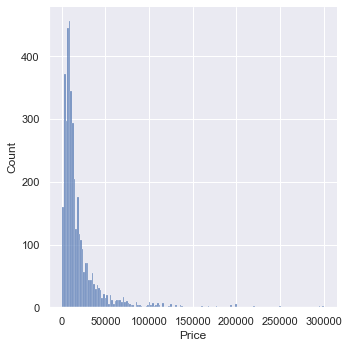

In [270]:
sns.displot(df['Price'])

### Dealing with outliers

In [271]:
q = df['Price'].quantile(0.99)
data_1 = df[df['Price']<q]
data_1.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Year
count,3984,3984.00,3984,3984.00,3984.00,3984,3984.00
unique,7,NaN,6,NaN,NaN,4,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,NaN
freq,880,NaN,1528,NaN,NaN,1853,NaN
mean,NaN,17837.12,NaN,165.12,2.74,NaN,2006.29
std,NaN,18976.27,NaN,102.77,4.96,NaN,6.67
min,NaN,600.00,NaN,0.00,0.60,NaN,1969.00
25%,NaN,6980.00,NaN,93.00,1.80,NaN,2002.75
50%,NaN,11400.00,NaN,160.00,2.20,NaN,2007.00
75%,NaN,21000.00,NaN,230.00,3.00,NaN,2011.00


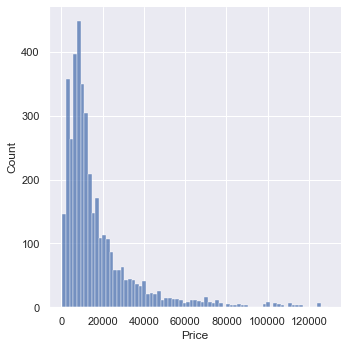

In [272]:
sns.displot(data_1['Price'])

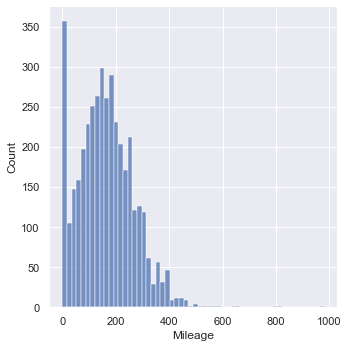

In [273]:
sns.displot(df['Mileage'])

In [274]:
q = data_1['Mileage'].quantile(0.99)
data_2 = data_1[data_1['Mileage']<q]

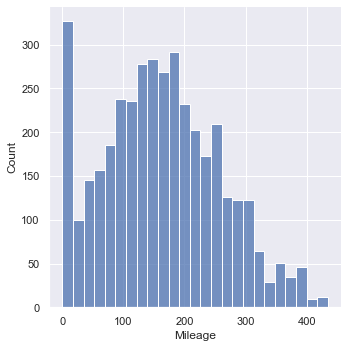

In [275]:
sns.displot(data_2['Mileage'])

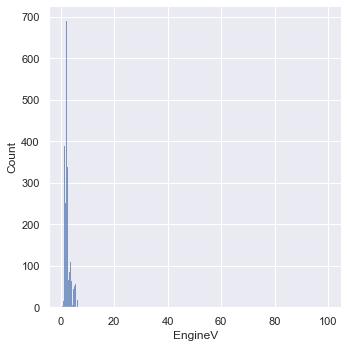

In [276]:
sns.displot(df['EngineV'])

In [277]:
data_3 = data_2[data_2['EngineV']<6.5]

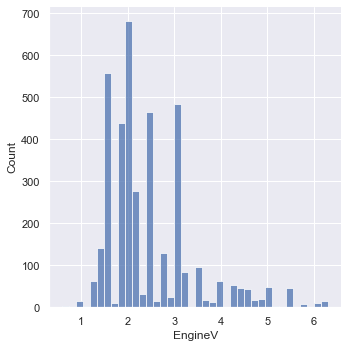

In [278]:
sns.displot(data_3['EngineV'])

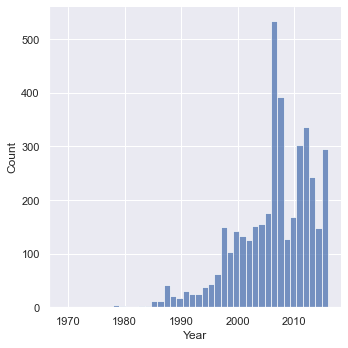

In [279]:
sns.displot(df['Year'])

In [280]:
q = data_3['Year'].quantile(0.01)
data_4 = data_3[data_3['Year']>q]

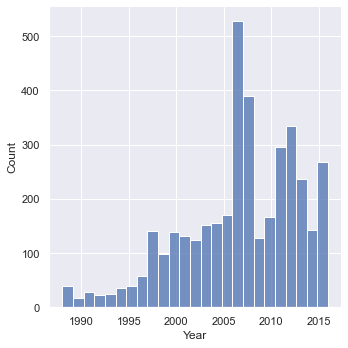

In [281]:
sns.displot(data_4['Year'])

In [282]:
data_cleaned = data_4.reset_index(drop=True)

In [283]:
data_cleaned.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Year
count,3867,3867.00,3867,3867.00,3867.00,3867,3867.00
unique,7,NaN,6,NaN,NaN,4,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,NaN
freq,848,NaN,1467,NaN,NaN,1807,NaN
mean,NaN,18194.46,NaN,160.54,2.45,NaN,2006.71
std,NaN,19085.86,NaN,95.63,0.95,NaN,6.10
min,NaN,800.00,NaN,0.00,0.60,NaN,1988.00
25%,NaN,7200.00,NaN,91.00,1.80,NaN,2003.00
50%,NaN,11700.00,NaN,157.00,2.20,NaN,2008.00
75%,NaN,21700.00,NaN,225.00,3.00,NaN,2012.00


## Checking the OLS assumptions

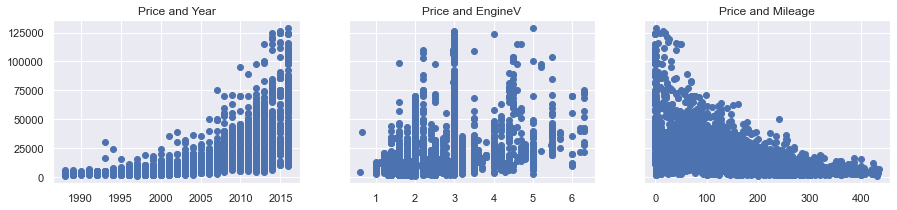

In [284]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3))
ax1.scatter(data_cleaned['Year'],data_cleaned['Price'])
ax1.set_title('Price and Year')
ax2.scatter(data_cleaned['EngineV'],data_cleaned['Price'])
ax2.set_title('Price and EngineV')
ax3.scatter(data_cleaned['Mileage'],data_cleaned['Price'])
ax3.set_title('Price and Mileage')

plt.show()

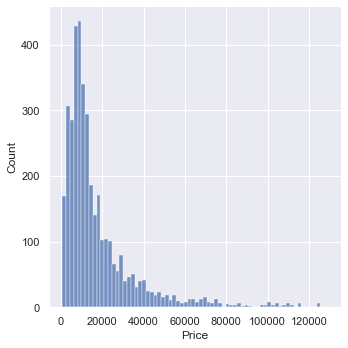

In [285]:
sns.displot(data_cleaned['Price'])

### Relaxing the assumptions

In [286]:
log_price = np.log(data_cleaned['Price'])
data_cleaned['log_price'] = log_price
data_cleaned

,Brand,Price,Body,Mileage,EngineV,Engine Type,Year,log_price
0,BMW,4200.00,sedan,277,2.00,Petrol,1991,8.34
1,Mercedes-Benz,7900.00,van,427,2.90,Diesel,1999,8.97
2,Mercedes-Benz,13300.00,sedan,358,5.00,Gas,2003,9.50
3,Audi,23000.00,crossover,240,4.20,Petrol,2007,10.04
4,Toyota,18300.00,crossover,120,2.00,Petrol,2011,9.81
...,...,...,...,...,...,...,...,...
3862,Volkswagen,11500.00,van,163,2.50,Diesel,2008,9.35
3863,Toyota,17900.00,sedan,35,1.60,Petrol,2014,9.79
3864,Mercedes-Benz,125000.00,sedan,9,3.00,Diesel,2014,11.74
3865,BMW,6500.00,sedan,1,3.50,Petrol,1999,8.78


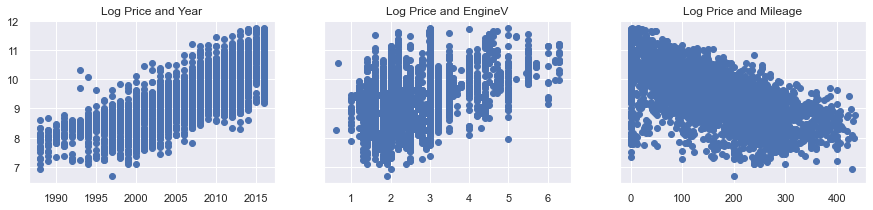

In [287]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3))
ax1.scatter(data_cleaned['Year'],data_cleaned['log_price'])
ax1.set_title('Log Price and Year')
ax2.scatter(data_cleaned['EngineV'],data_cleaned['log_price'])
ax2.set_title('Log Price and EngineV')
ax3.scatter(data_cleaned['Mileage'],data_cleaned['log_price'])
ax3.set_title('Log Price and Mileage')


plt.show()

In [288]:
data_cleaned = data_cleaned.drop(['Price'],axis=1)

### Multicollinearity

In [289]:
data_cleaned.columns.values

array(['Brand', 'Body', 'Mileage', 'EngineV', 'Engine Type', 'Year',
       'log_price'], dtype=object)

In [290]:
variables = data_cleaned[['Mileage','Year','EngineV']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns

In [291]:
data_no_multicollinearity = data_cleaned.drop(['Year'],axis=1)
data_no_multicollinearity

,Brand,Body,Mileage,EngineV,Engine Type,log_price
0,BMW,sedan,277,2.00,Petrol,8.34
1,Mercedes-Benz,van,427,2.90,Diesel,8.97
2,Mercedes-Benz,sedan,358,5.00,Gas,9.50
3,Audi,crossover,240,4.20,Petrol,10.04
4,Toyota,crossover,120,2.00,Petrol,9.81
...,...,...,...,...,...,...
3862,Volkswagen,van,163,2.50,Diesel,9.35
3863,Toyota,sedan,35,1.60,Petrol,9.79
3864,Mercedes-Benz,sedan,9,3.00,Diesel,11.74
3865,BMW,sedan,1,3.50,Petrol,8.78


## Create dummy variables

In [292]:
data_with_dummies = pd.get_dummies(data_no_multicollinearity, drop_first=True)

In [293]:
data_with_dummies.head()

,Mileage,EngineV,log_price,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol
0,277,2.00,8.34,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,427,2.90,8.97,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,358,5.00,9.50,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,240,4.20,10.04,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,120,2.00,9.81,0,0,0,0,1,0,0,0,0,0,0,0,0,1


### Rearrange a bit

In [294]:
data_with_dummies.columns.values

array(['Mileage', 'EngineV', 'log_price', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol'], dtype=object)

In [295]:
cols = ['log_price', 'Mileage', 'EngineV', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol']

In [296]:
data_preprocessed = data_with_dummies[cols]
data_preprocessed.head()

,log_price,Mileage,EngineV,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol
0,8.34,277,2.00,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,8.97,427,2.90,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,9.50,358,5.00,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,10.04,240,4.20,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,9.81,120,2.00,0,0,0,0,1,0,0,0,0,0,0,0,0,1


## Linear regression model

### Declare the inputs and the targets

In [297]:
targets = data_preprocessed['log_price']
inputs = data_preprocessed.drop(['log_price'],axis=1)

### Scale the data

In [298]:
scaler = StandardScaler()
scaler.fit(inputs)

StandardScaler()

In [299]:
inputs_scaled = scaler.transform(inputs)

### Train Test Split

In [300]:
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=365)

### Create the regression

In [301]:
reg = LinearRegression()
reg.fit(x_train,y_train)

LinearRegression()

In [302]:
y_hat = reg.predict(x_train)

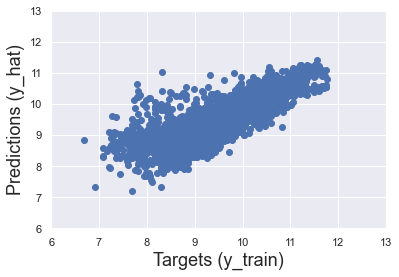

In [303]:
plt.scatter(y_train, y_hat)
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

Text(0.5, 1.0, 'Residuals PDF')

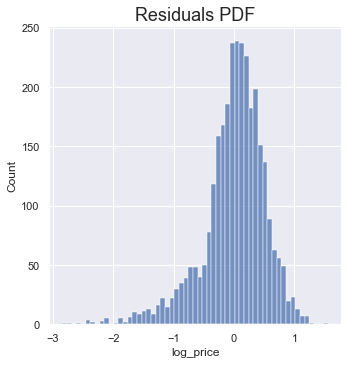

In [304]:
#Residual is the difference between the targets and the predictions
sns.displot(y_train - y_hat)
plt.title("Residuals PDF", size=18)

In [305]:
reg.score(x_train,y_train)

0.6327932829432332

### Finding the weights and bias

In [306]:
reg.intercept_

10.2640626568619

In [307]:
reg.coef_

array([-0.00538936,  0.23141616,  0.05961985,  0.14161872, -0.42447008,
       -0.4128625 , -0.0647629 , -0.10125293, -0.68535634, -0.34242295,
       -0.46020198, -0.59152013, -0.38256155, -0.2106938 , -0.21434045,
       -0.1964267 ])

In [308]:
reg_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

,Features,Weights
0,Mileage,-0.01
1,EngineV,0.23
2,Brand_BMW,0.06
3,Brand_Mercedes-Benz,0.14
4,Brand_Mitsubishi,-0.42
5,Brand_Renault,-0.41
6,Brand_Toyota,-0.06
7,Brand_Volkswagen,-0.10
8,Body_hatch,-0.69
9,Body_other,-0.34


## Testing

In [309]:
y_hat_test = reg.predict(x_test)

In [310]:
x_test

,Mileage,EngineV,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol
1192,300,3.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3360,220,2.30,0,1,0,0,0,0,0,1,0,0,0,0,0,1
2350,105,1.40,0,0,0,1,0,0,0,0,1,0,0,0,0,1
3257,127,1.60,0,0,1,0,0,0,0,0,1,0,0,0,0,1
892,273,2.70,0,1,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935,180,3.20,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3757,107,1.60,0,0,0,0,0,1,0,0,1,0,0,1,0,0
3134,30,1.60,0,0,0,0,1,0,1,0,0,0,0,0,0,1
1369,1,3.50,0,0,0,0,1,0,0,0,0,0,1,0,0,1


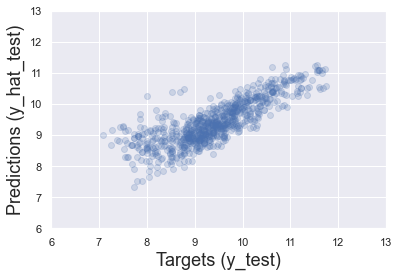

In [311]:
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

In [312]:
df_pf = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])
df_pf.head()

,Prediction
0,8290.96
1,10030.95
2,7728.51
3,7106.62
4,8946.42


In [313]:
df_pf['Target'] = np.exp(y_test)
df_pf

,Prediction,Target
0,8290.96,NaN
1,10030.95,7900.00
2,7728.51,NaN
3,7106.62,NaN
4,8946.42,NaN
...,...,...
769,26268.59,6950.00
770,10780.76,NaN
771,13713.03,NaN
772,33687.38,NaN


In [314]:
y_test = y_test.reset_index(drop=True)
y_test.head()

0   7.74
1   7.94
2   7.82
3   8.76
4   9.12
Name: log_price, dtype: float64

In [315]:
df_pf['Target'] = np.exp(y_test)
df_pf

,Prediction,Target
0,8290.96,2300.00
1,10030.95,2800.00
2,7728.51,2500.00
3,7106.62,6400.00
4,8946.42,9150.00
...,...,...
769,26268.59,29500.00
770,10780.76,9600.00
771,13713.03,18300.00
772,33687.38,68500.00


In [316]:
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']

In [317]:
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf

,Prediction,Target,Residual,Difference%
0,8290.96,2300.00,-5990.96,260.48
1,10030.95,2800.00,-7230.95,258.25
2,7728.51,2500.00,-5228.51,209.14
3,7106.62,6400.00,-706.62,11.04
4,8946.42,9150.00,203.58,2.22
...,...,...,...,...
769,26268.59,29500.00,3231.41,10.95
770,10780.76,9600.00,-1180.76,12.30
771,13713.03,18300.00,4586.97,25.07
772,33687.38,68500.00,34812.62,50.82


In [318]:
df_pf.describe()

,Prediction,Target,Residual,Difference%
count,774.00,774.00,774.00,774.00
mean,15560.32,18165.82,2605.49,48.39
std,12785.18,19967.86,11277.43,79.15
min,1534.54,1200.00,-31976.55,0.10
25%,7364.90,6900.00,-2340.80,13.24
50%,10989.86,11600.00,638.12,27.33
75%,19119.87,20500.00,3916.90,48.16
max,76166.15,126000.00,87273.60,854.05


In [319]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_pf.sort_values(by=['Difference%'])

,Prediction,Target,Residual,Difference%
258,11888.15,11900.00,11.85,0.10
23,12913.98,12900.00,-13.98,0.11
165,9389.32,9400.00,10.68,0.11
508,14953.31,15000.00,46.69,0.31
261,48364.18,48535.50,171.32,0.35
...,...,...,...,...
664,10388.37,1700.00,-8688.37,511.08
639,32585.69,4999.00,-27586.69,551.84
635,9577.44,1450.00,-8127.44,560.51
609,8192.76,1200.00,-6992.76,582.73


In [332]:
reg.feature_names_in_

array(['Mileage', 'EngineV', 'Brand_BMW', 'Brand_Mercedes-Benz',
       'Brand_Mitsubishi', 'Brand_Renault', 'Brand_Toyota',
       'Brand_Volkswagen', 'Body_hatch', 'Body_other', 'Body_sedan',
       'Body_vagon', 'Body_van', 'Engine Type_Gas', 'Engine Type_Other',
       'Engine Type_Petrol'], dtype=object)

In [326]:
reg.predict(np.array([0,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0]).reshape(1, -1))

C:\Users\aldan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([9.92103439])